<H1>Explore SA-GAWLER CHALLENGE
<br><H2>   Data Preparation

In recent years,researches on processing geochemical data,identifying geochemical anomalies using machine learning and data science has made important progress.This notebook intents a kick start for such an initiative in finding inexplored resources of Southern Australia."Past is the key to present"-Sir Charles Lyell,this notebook focuses on the basic pre-processing of the available data that are required for the challenge.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import folium
from tqdm import trange
from collections import Counter

Depending on the requirement, the data can be selected using the following codes for pre-processing.In order to perform this activity,we need a thorough understanding of the datasets available freely and their required usages.

In [2]:
folder_name = r"C:\Users\jossnithin\Downloads\ExploreSA Gawler\Data\Unearthed_5_SARIG_Data_Package\SARIG_Data_Package\\"
# Get names of Mineral Deposit csv files
md_files_names = [file_name for file_name in os.listdir(folder_name) if file_name.startswith('sarig_md')]
print(md_files_names)   

['sarig_md_commodity_exp.csv', 'sarig_md_details_exp.csv', 'sarig_md_mineralogy_exp.csv', 'sarig_md_reference_exp.csv', 'sarig_md_zone_hr_lith_exp.csv', 'sarig_md_zone_lith_exp.csv']


In [3]:
# Get the shape of Mineral Deposit csv files
for file in md_files_names:
    df = pd.read_csv(os.path.join(folder_name + file), encoding = "ISO-8859-1")
    print(df.shape)

(11017, 14)
(8694, 28)
(16010, 17)
(14680, 19)
(4398, 19)
(8651, 20)


<H2>Loading Data

In [4]:
# Load csv Data
md_details = pd.read_csv(os.path.join(folder_name + 'sarig_md_details_exp.csv'), encoding = "ISO-8859-1")
md_commodity = pd.read_csv(os.path.join(folder_name + 'sarig_md_commodity_exp.csv'), encoding = "ISO-8859-1")
md_mineralogy = pd.read_csv(os.path.join(folder_name + 'sarig_md_mineralogy_exp.csv'), encoding = "ISO-8859-1")
md_zone_hr_lith = pd.read_csv(os.path.join(folder_name + 'sarig_md_zone_hr_lith_exp.csv'), encoding = "ISO-8859-1")
md_zone_lith = pd.read_csv(os.path.join(folder_name + 'sarig_md_zone_lith_exp.csv'), encoding = "ISO-8859-1")

<H2>Exploratory Data Analysis of Mineral Deposit Datasets

The source of our dataset is SARIG repo. 
The dataset names are the following:

<br>
'sarig_md_commodity_exp.csv'<br>
'sarig_md_details_exp.csv'<br>
'sarig_md_mineralogy_exp.csv'<br>
'sarig_md_reference_exp.csv'<br>
'sarig_md_zone_hr_lith_exp.csv'<br>
'sarig_md_zone_lith_exp.csv'<br>



The EDA is done in the above datasets. The below process is done to get an idea of discovery of various commodity over the years.

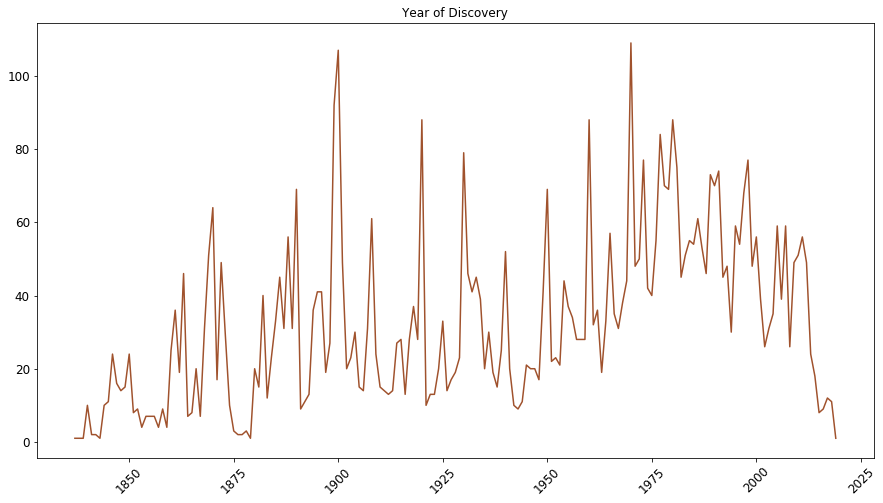

In [5]:
# Select relevant columns
md_details = md_details[['MINERAL_DEPOSIT_NO', 'DISCOVERY_YEAR', 'COMMODITIES', 'MINEROLOGY_ORE',
                         'MINEROLOGY_GANGUE', 'SITE_NO', 'ZONE_GDA2020', 'LONGITUDE_GDA2020', 'LATITUDE_GDA2020', 
                         'SURVEY_METHOD']]
md_details = md_details.fillna('-')

md_details['DISCOVERY_YEAR'].value_counts()[1:].sort_index().plot(figsize=(15,8), title='Year of Discovery', color='sienna',
                                                                  rot=45, fontsize=12, legend=False)
plt.show()

Here we display the data in the map to get a visual understanding of the data

In [6]:
md_details['LATITUDE_GDA2020'] = md_details['LATITUDE_GDA2020'].apply(lambda x:round(x,2))
md_details['LONGITUDE_GDA2020'] = md_details['LONGITUDE_GDA2020'].apply(lambda x:round(x,2))
md_density = md_details.groupby(['LATITUDE_GDA2020','LONGITUDE_GDA2020'])['MINERAL_DEPOSIT_NO'].count().reset_index()

In [7]:
# Distribution of Mineral Deposits
m = folium.Map(location=[md_density['LATITUDE_GDA2020'].mean(), md_density['LONGITUDE_GDA2020'].mean()], zoom_start=4)
 
for i in trange(0,len(md_density)):
    folium.Circle(
      location=[md_density.iloc[i]['LATITUDE_GDA2020'], md_density.iloc[i]['LONGITUDE_GDA2020']],
      radius=md_density.iloc[i]['MINERAL_DEPOSIT_NO']*1000,
      color='crimson',
      fill=True,
      fill_color='crimson'
   ).add_to(m)
m

100%|██████████| 7163/7163 [00:04<00:00, 1693.18it/s]


One can cleary see that the dataset contains information of area outside Gawler region. Reducing the area to Galwer region can help in creating a better quality model.

The top ten commodities are displayed using a bar graph. This clearly shows that Copper and Gold are the most abundant commodities in the region

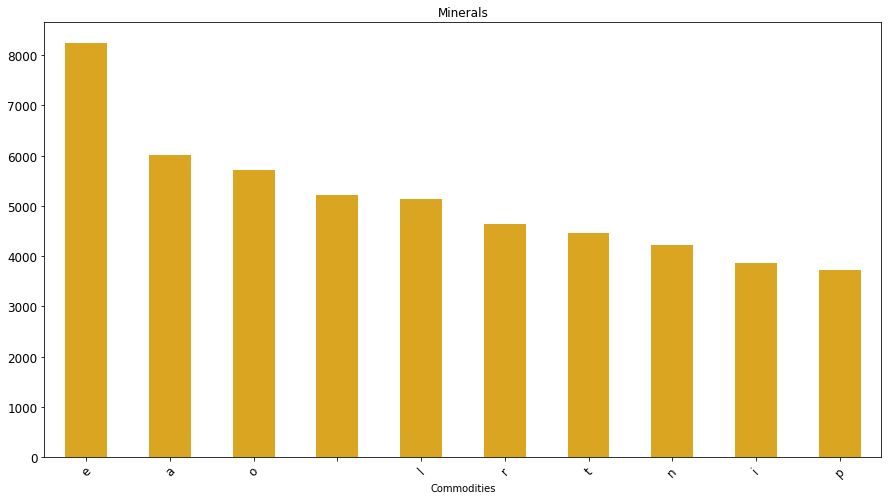

In [8]:
commodities = dict(Counter(md_details['COMMODITIES'].sum()))
commodities_df = pd.DataFrame({'Commodities':list(commodities.keys()), 
                               'Count':list(commodities.values())}).set_index('Commodities').sort_values('Count',
                                                                                                         ascending=False)

# Top 10 Mineral commodities found
commodities_df[:10].plot(kind='bar', figsize=(15,8), title='Minerals', color='goldenrod', rot=45, fontsize=12, legend=False)

<H2> Data Cleaning

The idea of pre-processing starts from here:
    Clearing up the duplicate values where we use the logic of dropping off the columns if we find 75% of data missing.Thus         helping in improving data quality

In [9]:
#Function to clean and drop columns with large missing values
def clean_df(df):
    # Remove duplicate row
    df = df.drop_duplicates()

    # Drop columns with more than 75% missing values
    for col in df.columns:
        if df[col].isna().sum() > (0.75 * len(df)):
            df = df.drop(col, axis=1)
    return df

In [10]:

# Clean Data and dropping columns with large  missing values
md_details = clean_df(md_details)
md_commodity = clean_df(md_commodity)
md_mineralogy = clean_df(md_mineralogy)
md_zone_hr_lith = clean_df(md_zone_hr_lith)
md_zone_lith = clean_df(md_zone_lith)

<H2>Processing

Displaying head of 'sarig_md_details_exp.csv' reveals that commodities column contains multiple elements. To do proper prediction we need to split them into different rows. Analysis of 'sarig_md_commodity_exp.csv' reveals that it contains the above required data in separate rows. So we will be using this dataframe for further processing.

In [11]:

md_details['COMMODITIES'] = md_details['COMMODITIES'].apply(lambda x:x.split(',  '))
md_details['MINEROLOGY_ORE'] = md_details['MINEROLOGY_ORE'].apply(lambda x:x.split(',  '))
md_details['MINEROLOGY_GANGUE'] = md_details['MINEROLOGY_GANGUE'].apply(lambda x:x.split(',  '))
md_details.head()

MINERAL_DEPOSIT_NO DISCOVERY_YEAR                    COMMODITIES  \
0                  17           1899                       [Copper]   
1                  21           1899                       [Copper]   
2                  33           1987                         [Iron]   
3                  34           1991  [Rare Earths, Heavy Minerals]   
4                  35           1970                       [Copper]   

                                   MINEROLOGY_ORE  \
0  [Bornite, Chalcocite, Chalcopyrite, Malachite]   
1                                     [Malachite]   
2                                     [Magnetite]   
3                    [Ilmenite, Monazite, Zircon]   
4                                       [Cuprite]   

                                   MINEROLOGY_GANGUE  SITE_NO  ZONE_GDA2020  \
0                                 [Quartz, Siderite]   210457            54   
1  [Barite, Calcite, Iron oxide (non specific), Q...   210458            54   
2                                 [Feldspar, Quartz]   209556            52   
3                                        [Magnetite]   209576            53   
4                                                [-]   209575            53   

   LONGITUDE_GDA2020  LATITUDE_GDA2020  \
0             138.40            -30.88   
1             138.40            -30.87   
2             131.92            -30.63   
3             133.01            -26.02   
4             133.23            -26.94   

                                 SURVEY_METHOD  
0                           Google Earth image  
1                           Google Earth image  
2  Sourced from documents (PLANS, ENV, RB,etc)  
3                             Uncontrolled map  
4                           Google Earth image

In [12]:
md_commodity.head()

MINERAL_DEPOSIT_NO        DEPOSIT_NAME COMMODITY_CODE  COMMODITY_NAME  \
0                  17  ENTERPRISE BELTANA             Cu          Copper   
1                  21      HARVEYS RETURN             Cu          Copper   
2                  33              OOLDEA             Fe            Iron   
3                  34       VICTORY DOWNS            REE     Rare Earths   
4                  34       VICTORY DOWNS           HMIN  Heavy Minerals   

  SIGNIFICANCE  SITE_NO  EASTING_GDA2020  NORTHING_GDA2020  ZONE_GDA2020  \
0        MAJOR   210457        251540.85        6581151.56            54   
1        MAJOR   210458        251431.67        6581960.86            54   
2        MAJOR   209556        779511.42        6607901.66            52   
3        MAJOR   209576        300730.84        7120631.49            53   
4        MINOR   209576        300730.84        7120631.49            53   

   LONGITUDE_GDA2020  LATITUDE_GDA2020  LONGITUDE_GDA94  LATITUDE_GDA94  
0         138.401168        -30.876863       138.401157      -30.876849  
1         138.400224        -30.869545       138.400213      -30.869531  
2         131.916017        -30.628870       131.916008      -30.628856  
3         133.008773        -26.019552       133.008764      -26.019538  
4         133.008773        -26.019552       133.008764      -26.019538

<br>Separating the 10 commodity data into different csv files so that we can separately create classification models for each commodity

In [13]:
top_10 = list(md_commodity['COMMODITY_NAME'].value_counts()[:10].index.values)
comm_dict = {}
for comm in top_10:
    comm_csv_true = md_commodity[md_commodity['COMMODITY_NAME'] == comm]
    comm_csv_false = md_commodity[md_commodity['COMMODITY_NAME'] != comm]
    comm_csv_true['flag'], comm_csv_false['flag'] = 1, 0
    comm_csv = comm_csv_true.append(comm_csv_false)
    comm_csv = comm_csv.drop_duplicates(['MINERAL_DEPOSIT_NO', 'DEPOSIT_NAME', 'LONGITUDE_GDA2020', 'LATITUDE_GDA2020'])
    comm_csv = comm_csv.sample(frac=1)
    comm_dict[comm] = comm_csv
    comm_csv.to_csv(comm+'.csv')

C:\Users\jossnithin\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


We here explore the newly created Gold data set

It is clear from the below figure that Gold was found in 1519 locations

![Gold Data](Figures/Gold%20Bar%20graph.png "Gold Data")

The map below shows the geo locations in which gold was found and not found

![gold Map](Figures/map%20gold.png "Gold Data")

By using this location data of each commodities, we can create a classifier model using the top 10 commodities. These models can be used to predict whether there is a potential for a mineral in a particular location based on historic data. The model created from the above data will completely be based on mineral deposits. This model can be used to do preliminary test for minerals at a particular location.
Using other data like Hydrochemical data, we could create a more accurate model which requires input from physical site. This model can be applied after doing the preliminary test. 

The 10 commodity data is stored in 10 csv files in the cleaned_datasets



<H2>Additional Analysis

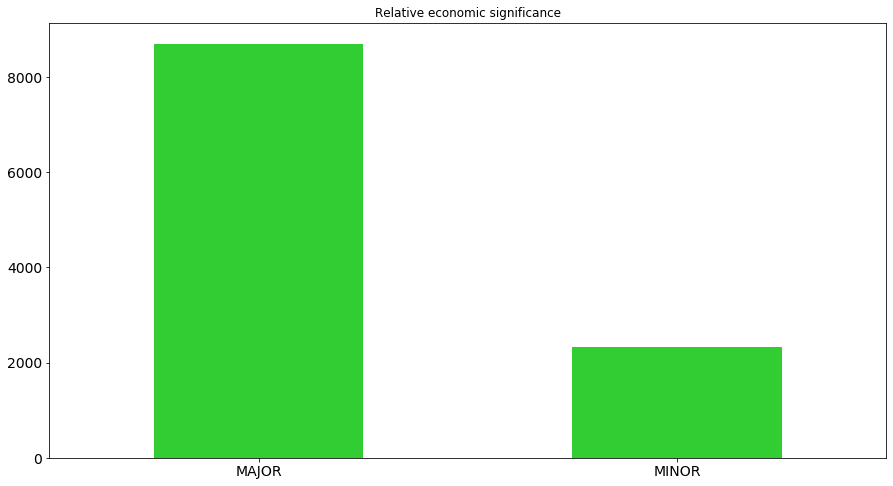

In [14]:
md_commodity = md_commodity[['MINERAL_DEPOSIT_NO', 'COMMODITY_NAME', 'SIGNIFICANCE']]

# Relative economic significance of the commodity to the mineral deposit
md_commodity['SIGNIFICANCE'].value_counts().plot(kind='bar', figsize=(15,8), title='Relative economic significance',
                                                 color='limegreen', rot=0, fontsize=14)

In [15]:
ore = dict(Counter(md_details['MINEROLOGY_ORE'].sum()))
ore_df = pd.DataFrame({'MINEROLOGY ORE':list(ore.keys()), 
                       'Count':list(ore.values())}).set_index('MINEROLOGY ORE').sort_values('Count', ascending=False)

gangue = dict(Counter(md_details['MINEROLOGY_GANGUE'].sum()))
gangue_df = pd.DataFrame({'MINEROLOGY GANGUE':list(gangue.keys()), 
                          'Count':list(gangue.values())}).set_index('MINEROLOGY GANGUE').sort_values('Count', ascending=False)

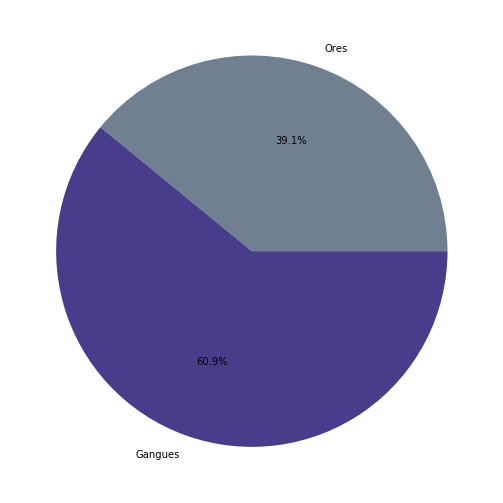

In [16]:
gangue_count = ore['-']
ore_count = gangue['-']

plt.figure(figsize=(15,9))
plt.pie([gangue_count, ore_count], labels=['Ores', 'Gangues'], colors=['slategrey', 'darkslateblue'], autopct='%1.1f%%',)
plt.show()

39.1% of the mineral types found in mineral deposits are Ores and the remaining 60.9% are gangues

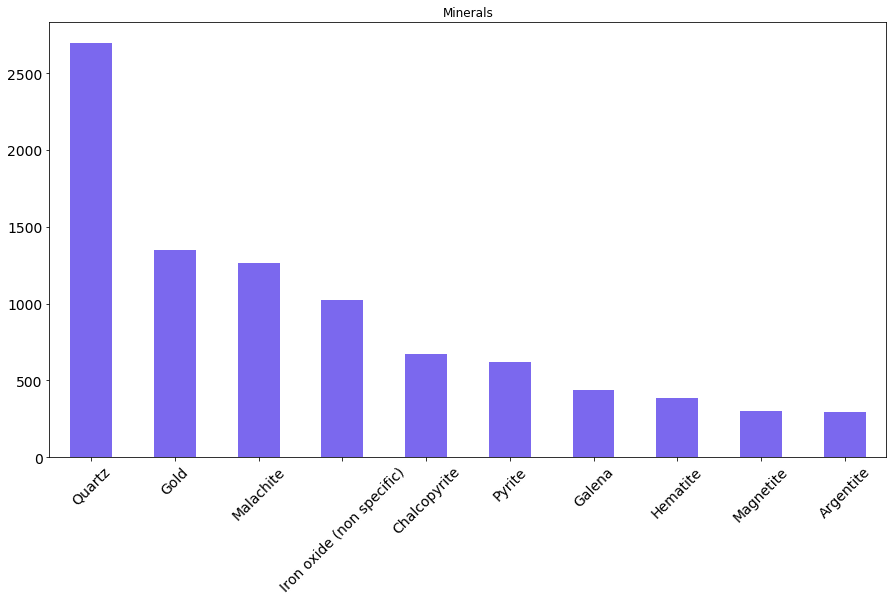

In [17]:
md_mineralogy = md_mineralogy[['MINERAL_DEPOSIT_NO', 'MINERAL', 'RELATIVE_ABUNDANCE_CODE', 'WEATHERING_PRODUCT']]

# Top 10 Minerals found
# Relative economic significance of the commodity to the mineral deposit
md_mineralogy['MINERAL'].value_counts()[:10].plot(kind='bar', figsize=(15,8), title='Minerals',
                                                  color='mediumslateblue', rot=45, fontsize=14)

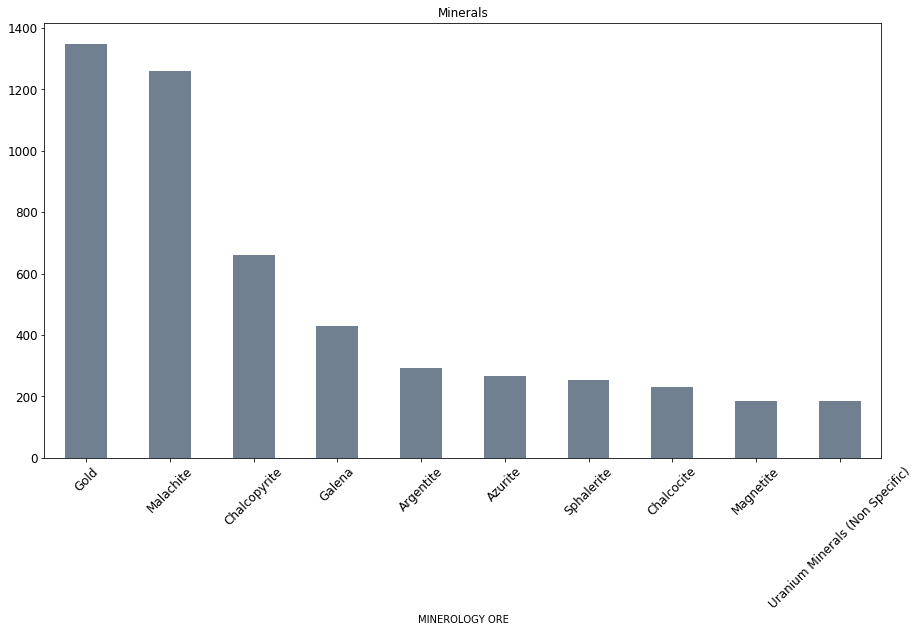

In [18]:
# Top 10 Minerals found in Ores
# There is no data for 3382 rows
ore_df[1:11].plot(kind='bar', figsize=(15,8), title='Minerals', color='slategrey', rot=45, fontsize=12, legend=False)

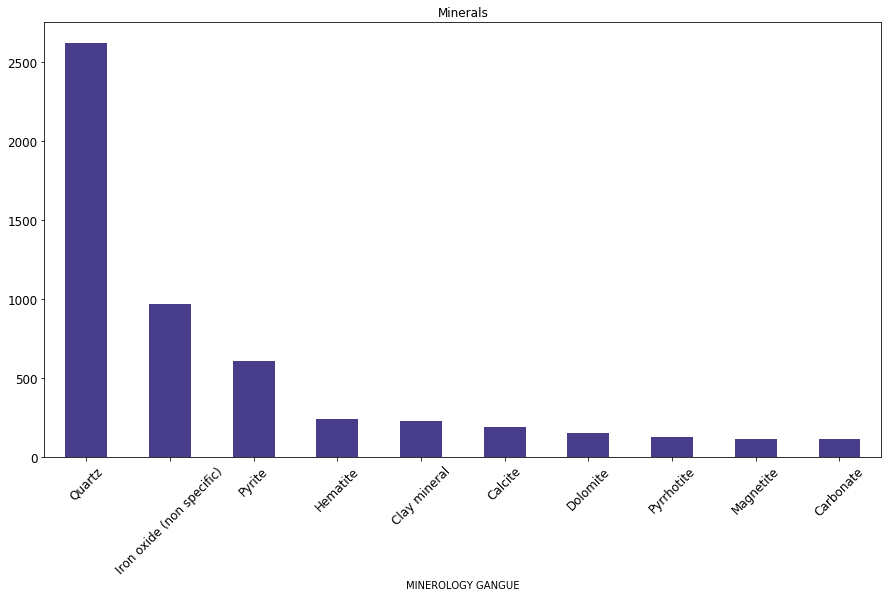

In [19]:
# Top 10 Minerals found in Gangues
# There is no data for 5273 rows
gangue_df[1:11].plot(kind='bar', figsize=(15,8), title='Minerals', color='darkslateblue', rot=45, fontsize=12, legend=False)

**Trace**    - **1-4 % by volume**  
**Minor**    - **5-29 % by volume**  
**Rare**     - **<1 % by volume**  
**Abundant** - **>70 % by volume**  
**Major**    - **30- 70 % by volume**  

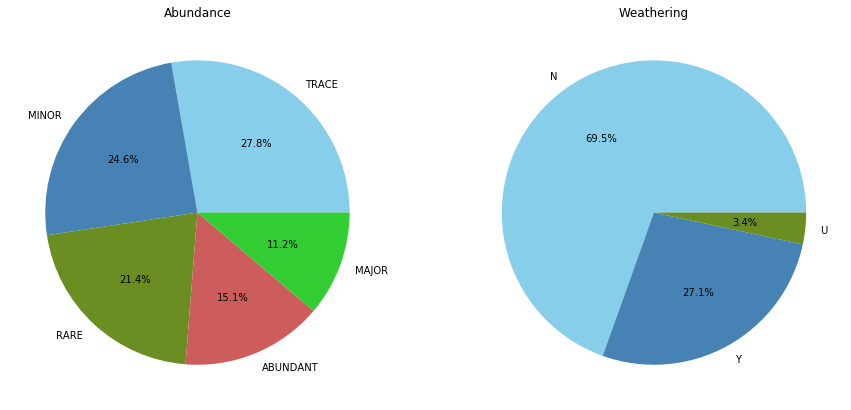

In [20]:
# Abundance of Minerals
abundance_df = md_mineralogy['RELATIVE_ABUNDANCE_CODE'].value_counts()

plt.figure(figsize=(15,16))
plt.subplot(221)
plt.pie(abundance_df.values, labels=abundance_df.index.values, colors=['skyblue', 'steelblue', 'olivedrab', 'indianred',
                                                                    'limegreen'], autopct='%1.1f%%')
plt.title('Abundance')

# Whether mineral is a product of weathering
weathering_df = md_mineralogy['WEATHERING_PRODUCT'].value_counts()

plt.subplot(222)
plt.pie(weathering_df.values, labels=weathering_df.index.values, colors=['skyblue', 'steelblue', 'olivedrab'],
        autopct='%1.1f%%')
plt.title('Weathering')

plt.show()

In [21]:
md_zone_lith = md_zone_lith[['MINERAL_DEPOSIT_NO', 'LITHOLOGY', 'HR_STRAT_UNIT']]
md_zone_hr_lith = md_zone_hr_lith[['MINERAL_DEPOSIT_NO', 'LITHOLOGY', 'HR_STRAT_UNIT']]

In [22]:

md_zone_lith.head()

MINERAL_DEPOSIT_NO                               LITHOLOGY  \
0                  17                        Mesothermal Vein   
1                  21                 Vein (Undifferentiated)   
2                  33  Quartz-Magnetite Rock (Undiff. Origin)   
3                  34                                    Sand   
4                  35                 Vein (Undifferentiated)   

                         HR_STRAT_UNIT  
0                   quartz vein unit 4  
1                   quartz vein unit 4  
2                Mesoproterozoic rocks  
3  Holocene alluvial/fluvial sediments  
4                          quartz vein

In [23]:
combined_df = pd.DataFrame()

for file in md_files_names:
    if len(combined_df) == 0:
        combined_df = pd.read_csv(os.path.join(folder_name + file), encoding = "ISO-8859-1")
    else:
        combined_df = combined_df.merge(pd.read_csv(os.path.join(folder_name + file), encoding = "ISO-8859-1"),
                                        on = 'MINERAL_DEPOSIT_NO')
print(combined_df.shape)
combined_df.head()

(91127, 112)


MINERAL_DEPOSIT_NO      DEPOSIT_NAME_x COMMODITY_CODE COMMODITY_NAME  \
0                  17  ENTERPRISE BELTANA             Cu         Copper   
1                  17  ENTERPRISE BELTANA             Cu         Copper   
2                  17  ENTERPRISE BELTANA             Cu         Copper   
3                  17  ENTERPRISE BELTANA             Cu         Copper   
4                  17  ENTERPRISE BELTANA             Cu         Copper   

  COMMODITY_CONFIDENCE SIGNIFICANCE  SITE_NO_x  EASTING_GDA2020_x  \
0                  NaN        MAJOR     210457          251540.85   
1                  NaN        MAJOR     210457          251540.85   
2                  NaN        MAJOR     210457          251540.85   
3                  NaN        MAJOR     210457          251540.85   
4                  NaN        MAJOR     210457          251540.85   

   NORTHING_GDA2020_x  ZONE_GDA2020_x  ...  \
0          6581151.56              54  ...   
1          6581151.56              54  ...   
2          6581151.56              54  ...   
3          6581151.56              54  ...   
4          6581151.56              54  ...   

                          STRAT_DESCRIPTION_y  \
0  Undifferentiated ferruginous quartz veins.   
1  Undifferentiated ferruginous quartz veins.   
2  Undifferentiated ferruginous quartz veins.   
3  Undifferentiated ferruginous quartz veins.   
4  Undifferentiated ferruginous quartz veins.   

                   STRAT_UNIT_MODIFIER  SITE_NO_y  EASTING_GDA2020_y  \
0  cupriferous rather than ferruginous     210457          251540.85   
1  cupriferous rather than ferruginous     210457          251540.85   
2  cupriferous rather than ferruginous     210457          251540.85   
3  cupriferous rather than ferruginous     210457          251540.85   
4  cupriferous rather than ferruginous     210457          251540.85   

  NORTHING_GDA2020_y ZONE_GDA2020_y  LONGITUDE_GDA2020_y LATITUDE_GDA2020_y  \
0         6581151.56             54           138.401168         -30.876863   
1         6581151.56             54           138.401168         -30.876863   
2         6581151.56             54           138.401168         -30.876863   
3         6581151.56             54           138.401168         -30.876863   
4         6581151.56             54           138.401168         -30.876863   

  LONGITUDE_GDA94_y LATITUDE_GDA94_y  
0        138.401157       -30.876849  
1        138.401157       -30.876849  
2        138.401157       -30.876849  
3        138.401157       -30.876849  
4        138.401157       -30.876849  

[5 rows x 112 columns]

In [24]:
# Remove duplicate row
combined_df = combined_df.drop_duplicates()

# Remove duplicate cols
combined_df = combined_df.T.drop_duplicates().T
print(combined_df.shape)

(91127, 69)


In [25]:
# Drop columns with more than 75% missing values
for col in combined_df.columns:
    if combined_df[col].isna().sum() > (0.75 * len(combined_df)):
        combined_df = combined_df.drop(col, axis=1)
print(combined_df.shape)

(91127, 61)
